In [0]:
from google.colab import drive




drive.mount('/content/drive')


Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


# Importing Libraries ,word embeddings and Data


In [0]:
import pandas as pd
import numpy as np
from nltk.stem.wordnet import WordNetLemmatizer
from nltk.corpus import stopwords
from sklearn.model_selection import train_test_split
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import KFold
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn import metrics
from sklearn.metrics import roc_curve,auc
import nltk
import gensim
from sklearn import metrics
from sklearn.metrics import roc_curve,auc
import matplotlib.pyplot as plt
from textblob import TextBlob
import matplotlib.pyplot as plt
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('brown')
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')
import warnings
warnings.filterwarnings('ignore')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.
[nltk_data] Downloading package brown to /root/nltk_data...
[nltk_data]   Unzipping corpora/brown.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.


In [0]:

path='/content/drive/My Drive/GoogleNews-vectors-negative300.bin'

In [0]:
%%time
word2vector=gensim.models.KeyedVectors.load_word2vec_format(path, binary=True)

CPU times: user 47.8 s, sys: 7.17 s, total: 55 s
Wall time: 2min 28s


In [0]:
def extract_noun_and_verb_phrases(answer):
  text = nltk.word_tokenize(answer)
  pos_tagged = nltk.pos_tag(text)
  sentence = filter(lambda x:x[1] == 'NN' or x[1] == 'VB',pos_tagged)
  sentence_list = [i for i in sentence]
  full_sentence = ''
  for i in sentence_list:
     full_sentence += ' '+i[0]
  return(full_sentence)

In [0]:
main_data=pd.read_csv('/content/Classified_data_combined.csv')

In [0]:
main_data=main_data[main_data['Classification']!=2]



In [0]:

main_data['Noun_Verb_Phrases'] = main_data['Answer'].apply(extract_noun_and_verb_phrases)

In [0]:
x=main_data.drop('Classification',axis=1)
y=main_data[['Classification']]

In [0]:
X_train,X_test,y_train,y_test = train_test_split(x,y,test_size = 0.2, random_state=303)

In [0]:


train_answers=X_train['Noun_Verb_Phrases']
test_answers=X_test['Noun_Verb_Phrases']
train_answers=train_answers.str.lower()
test_answers=test_answers.str.lower()
train_answers=train_answers.str.replace('[^a-z ]','')
test_answers=test_answers.str.replace('[^a-z ]','')


In [0]:
uniq_words = set()
train_answers.str.split(' ').apply(uniq_words.update)
uniq_words = list(uniq_words)
len(uniq_words)

stopwords = nltk.corpus.stopwords.words('english')
words = set(uniq_words) - set(stopwords)
words = list(words)
len(words)

list(uniq_words)[:5]

['', 'mind', 'principle', 'ivyproschoolcom', 'cofounder']

In [0]:
test_uniq_words = set()
test_answers.str.split(' ').apply(test_uniq_words.update)
test_uniq_words = list(test_uniq_words)
len(test_uniq_words)

stopwords = nltk.corpus.stopwords.words('english')
test_words = set(test_uniq_words) - set(stopwords)
test_words = list(test_words)
len(test_words)

list(test_uniq_words)[:5]

['', 'mind', 'principle', 'ivyproschoolcom', 'logic']

In [0]:
wordvectors = {}
for word in uniq_words:
    try:
        wordvectors[word] = word2vector[word]
    except:
        pass
len(wordvectors)


import gc
gc.collect()

86

In [0]:
test_wordvectors = {}
for word in test_uniq_words:
    try:
        test_wordvectors[word] = word2vector[word]
    except:
        pass
len(test_wordvectors)


import gc
gc.collect()

79

In [0]:
def sent_vectorizer(sent, model):
    sent_vec =[]
    numw = 0
    for w in sent:
        try:
            if numw == 0:
                sent_vec = model[w]
            else:
                sent_vec = np.add(sent_vec, model[w])
            numw+=1
        except:
            pass
    if len(sent_vec)==300:
        return list(np.asarray(sent_vec) / numw)
    else:
        return np.zeros(300)

In [0]:
def threshold_increase(preds):
  range_list=np.arange(0.45,0.55,0.01)
  for i in range_list:
    probability=[1 if j >i else 0 for j in preds]
    tn, fp, fn, tp =confusion_matrix(y_test,probability).ravel()
    print('threshold of {}'.format(i),'tn :',tn,'fp :', fp,'fn :', fn,'tp :', tp)
    

In [0]:
train_embeddings = []
for answer in train_answers:
    train_embeddings.append(sent_vectorizer(answer.split(' '), wordvectors))
    


In [0]:
test_embeddings = []
for answers in test_answers:
    test_embeddings.append(sent_vectorizer(answers.split(' '), wordvectors))


In [0]:
min_l = 0
for i in train_embeddings:
    if len(i)==0:
        min_l = min_l + 1
min_l

0


# Ada Boost Classifier

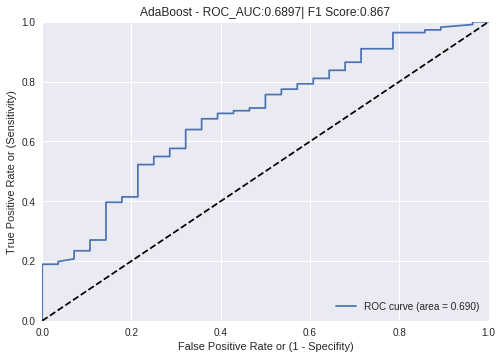

In [0]:
ab=AdaBoostClassifier(n_estimators=800)
ab.fit(train_embeddings,y_train)
predictions=ab.predict(test_embeddings)
proba=ab.predict_proba(test_embeddings)[:,1]

roc_auc_score_tf_ab = round(metrics.roc_auc_score(y_test,proba),4)
f1_score_tf_ab = round(metrics.f1_score(y_test,predictions),4)
accuracy_tf_ab = round(metrics.accuracy_score(y_test,predictions,4))

# Plot ROC AUC
fpr_tf_ab, tpr_tf_ab, thresholds = roc_curve(y_test,proba)
roc_auc_tf_ab = metrics.auc(fpr_tf_ab, tpr_tf_ab)
# Plot ROC curve
plt.plot(fpr_tf_ab, tpr_tf_ab, label='ROC curve (area = %0.3f)' % roc_auc_tf_ab)
plt.plot([0, 1], [0, 1], 'k--')  # random predictions curve
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate or (1 - Specifity)')
plt.ylabel('True Positive Rate or (Sensitivity)')
plt.title('AdaBoost - ROC_AUC:'+str(roc_auc_score_tf_ab)+'| F1 Score:'+str(f1_score_tf_ab))
plt.legend(loc="lower right")
plt.show()

#RandomForest


Best Grid Search Parameters:  {'max_depth': 30}


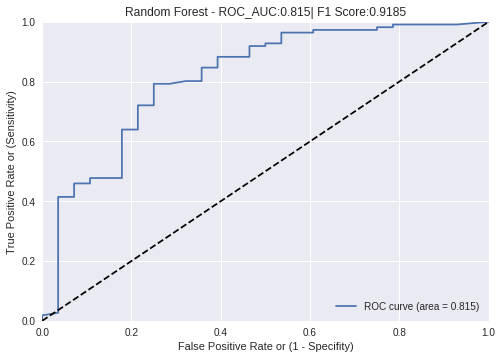

In [0]:
param_grid = dict(max_depth=np.arange(5,100,5))
model = RandomForestClassifier()
grid = GridSearchCV(estimator=model, param_grid=param_grid, scoring='roc_auc', cv=3)
grid_result = grid.fit(train_embeddings, y_train)
print('Best Grid Search Parameters: ',grid_result.best_params_)
rf = RandomForestClassifier(max_depth=grid_result.best_params_['max_depth'],n_estimators=800)
rf.fit(train_embeddings,y_train)
proba = rf.predict_proba(test_embeddings)[:,1]
predictions = rf.predict(test_embeddings)
roc_auc_score_tf_rf = round(metrics.roc_auc_score(y_test,proba),4)
f1_score_tf_rf = round(metrics.f1_score(y_test,predictions),4)
accuracy_tf_rf = round(metrics.accuracy_score(y_test,predictions,4))

# Plot ROC AUC
fpr_tf_rf, tpr_tf_rf, thresholds_tf_rf = roc_curve(y_test,proba)
roc_auc_tf_rf = metrics.auc(fpr_tf_rf, tpr_tf_rf)
# Plot ROC curve
plt.plot(fpr_tf_rf, tpr_tf_rf, label='ROC curve (area = %0.3f)' % roc_auc_tf_rf)
plt.plot([0, 1], [0, 1], 'k--')  # random predictions curve
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate or (1 - Specifity)')
plt.ylabel('True Positive Rate or (Sensitivity)')
plt.title('Random Forest - ROC_AUC:'+str(roc_auc_score_tf_rf)+'| F1 Score:'+str(f1_score_tf_rf))
plt.legend(loc="lower right")
plt.show()

# Gradient Boosting




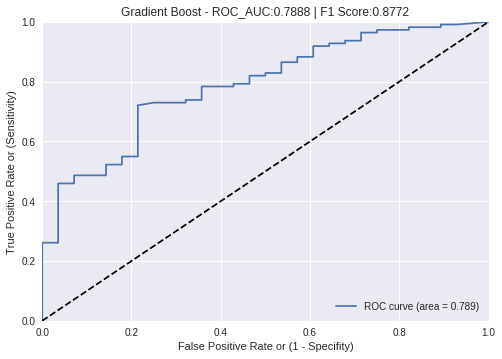

In [0]:
gb=GradientBoostingClassifier(n_estimators=800)
gb.fit(train_embeddings,y_train)
predictions=gb.predict(test_embeddings)
proba=gb.predict_proba(test_embeddings)[:,1]

roc_auc_score_tf_gb = round(metrics.roc_auc_score(y_test,proba),4)
f1_score_tf_gb = round(metrics.f1_score(y_test,predictions),4)
accuracy_tf_gb = round(metrics.accuracy_score(y_test,predictions,4))

# Plot ROC AUC
fpr_tf_gb, tpr_tf_gb, thresholds = roc_curve(y_test,proba)
roc_auc_tf_gb = metrics.auc(fpr_tf_gb, tpr_tf_gb)
# Plot ROC curve
plt.plot(fpr_tf_gb, tpr_tf_gb, label='ROC curve (area = %0.3f)' % roc_auc_tf_gb)
plt.plot([0, 1], [0, 1], 'k--')  # random predictions curve
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate or (1 - Specifity)')
plt.ylabel('True Positive Rate or (Sensitivity)')
plt.title('Gradient Boost - ROC_AUC:'+str(roc_auc_score_tf_gb)+' | F1 Score:'+str(f1_score_tf_gb))
plt.legend(loc="lower right")
plt.show()

# Model Comparison

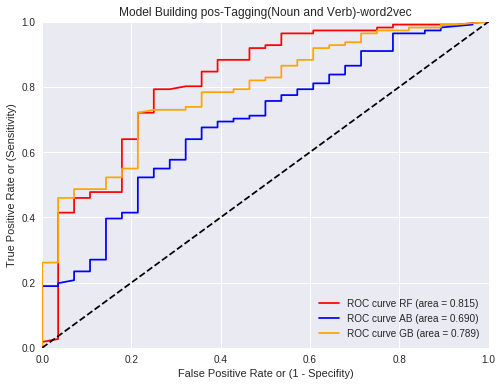

In [0]:
plt.figure(figsize=(8,6))
plt.plot(fpr_tf_rf, tpr_tf_rf, label='ROC curve RF (area = %0.3f)' % roc_auc_score_tf_rf,c='red')
plt.plot(fpr_tf_ab, tpr_tf_ab, label='ROC curve AB (area = %0.3f)' % roc_auc_tf_ab,c='blue')
plt.plot(fpr_tf_gb, tpr_tf_gb, label='ROC curve GB (area = %0.3f)' % roc_auc_tf_gb,c='orange')
plt.plot([0, 1], [0, 1], 'k--')  # random predictions curve
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.title('Model Building pos-Tagging(Noun and Verb)-word2vec')
plt.xlabel('False Positive Rate or (1 - Specifity)')
plt.ylabel('True Positive Rate or (Sensitivity)')
plt.legend(loc="lower right")
plt.show()